<a href="https://colab.research.google.com/github/dasparagjyoti/EEG-Channel-Selection-for-Emotion-Recognition/blob/main/Copy_of_channel_selection_and_feature_selection_BCI_arousal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Data Preprocessing**#

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import pickle  
drive._mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Deap/s01.dat', 'rb') as f:
 raw_data = pickle.load(f, encoding='latin1')

In [ ]:
pip install skfeature-chappers

     |████████████████████████████████| 66 kB 2.6 MB/s 


In [ ]:
import numpy as np
from skfeature.utility.construct_W import construct_W
from scipy.sparse import diags

def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [ ]:
data = raw_data['data']
labels = raw_data['labels']

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (40, 4)
Data:  (40, 40, 8064)


In [ ]:
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][0]>5): #high valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(1) # HVHA
		else:
			em_labels.append(0) # HVLA
	else: # low valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(2) #LVHA
		else:
			em_labels.append(3) # LVLA
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][1]>5): #high valence
			em_labels.append(0) # HVHA
	else: # low valence
			em_labels.append(1)

In [ ]:
print(em_labels)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


# Fisher's Score for Theta Band

In [ ]:
# load dataset
data_theta = pd.read_csv('/content/drive/MyDrive/1df_theta.csv')
# features from all the channels from the theta band only
data_theta.shape
data_theta['videos'] = em_labels
data_theta['videos'].unique()
X = data_theta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_theta['videos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_theta = fisher_score(X_train, y_train)

# Fisher Score for Alpha Band

In [ ]:
# load dataset
data_alpha = pd.read_csv('/content/drive/MyDrive/2df_alpha.csv')
# features from all the channels from the theta band only
data_alpha.shape
data_alpha['videos'] = em_labels
data_alpha['videos'].unique()
X = data_alpha[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_alpha['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_alpha = fisher_score(X_train, y_train)

# Fisher Score for Beta Band

In [ ]:
# load dataset
data_beta = pd.read_csv('/content/drive/MyDrive/3df_beta.csv')
# features from all the channels from the theta band only
data_beta.shape
data_beta['videos'] = em_labels
data_beta['videos'].unique()
X = data_beta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_beta['videos']
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_beta = fisher_score(X_train, y_train)

# Fisher Score for Gamma Band

In [ ]:
# load dataset
data_gamma = pd.read_csv('/content/drive/MyDrive/4df_gamma.csv')
# features from all the channels from the theta band only
data_gamma.shape
data_gamma['videos'] = em_labels
data_gamma['videos'].unique()
X = data_gamma[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_gamma['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_gamma = fisher_score(X_train, y_train)

# Total Avearge F-Score(Theta,Alpha,Beta,Gamma)

In [ ]:
final_f_score = (f_score_theta + f_score_alpha + f_score_beta + f_score_gamma)/4

In [ ]:
fvalues = pd.Series(final_f_score)
X_train = pd.DataFrame(X_train)
fvalues.index = X.columns
fvalues.sort_values(ascending=False)
fvalues.to_csv('fscore_final.csv')
print(fvalues)

Fp1    0.169451
AF3    0.232807
F3     0.257078
F7     0.079412
FC5    0.203454
FC1    0.196043
C3     0.187472
T7     0.140773
CP5    0.215465
CP1    0.201009
P3     0.285845
P7     0.325079
PO3    0.249167
O1     0.169598
Oz     0.180071
Pz     0.285443
Fp2    0.202628
AF4    0.162624
Fz     0.147973
F4     0.110062
F8     0.114605
FC6    0.130890
FC2    0.130900
Cz     0.005788
C4     0.151903
T8     0.195630
CP6    0.149990
CP2    0.140019
P4     0.209854
P8     0.130032
PO4    0.184067
O2     0.118841
dtype: float64


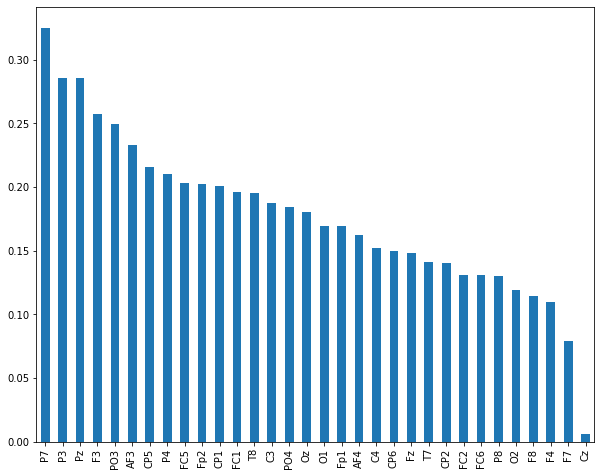

In [ ]:
fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))

# Classification

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
all_data = pd.read_csv("/content/drive/MyDrive/7AllMerged.csv")
data = all_data.drop('videos', axis = 1)

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Loading the dataset
def svmclassifier(channel_name):
  channel_names = []
  for i in range(0, len(channel_name)):
    draft = channel_name[i]
    channel_names.append(draft + "Alpha")
    channel_names.append(draft + "Beta")
    channel_names.append(draft + "Gamma")
    channel_names.append(draft + "Theta")
  x = data[channel_names]
  y = np.array(em_labels)

  # Implementing cross validation
  k = 10
  kf = KFold(n_splits = k)

  model = svm.SVC(kernel='poly')
  acc_score = []

  for train_index , test_index in kf.split(x):
      x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]
      model.fit(x_train, y_train)
      pred_values = model.predict(x_test)
      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)

  avg_acc_score = sum(acc_score)/k
  #print('accuracy of each fold - {}'.format(acc_score))
  print('Avg accuracy : {}'.format(avg_acc_score))

In [ ]:
svmclassifier(["P7"])

Avg accuracy : 0.575


In [ ]:
svmclassifier(["P7", "P3"])

Avg accuracy : 0.625


In [ ]:
svmclassifier(["P7", "P3", "F3"])

Avg accuracy : 0.65


In [ ]:
svmclassifier(["P7", "P3", "F3", "AF3"])

Avg accuracy : 0.7


In [ ]:
svmclassifier(["P7", "P3", "F3", "AF3", "Fp2"])

Avg accuracy : 0.7


In [ ]:
svmclassifier(["P7", "P3", "F3", "AF3", "Fp2", "AF4"])

Avg accuracy : 0.7


In [ ]:
svmclassifier(["P7", "P3", "F3", "AF3", "Fp2", "AF4", "C4"])

Avg accuracy : 0.7
